## Классификация новостей [AG's News Topic Classification Dataset](https://github.com/mhjabreel/CharCnn_Keras/tree/master/data/ag_news_csv)


Используется три архитектуры нейронных сетей:
- Одномерная сверточная нейросеть
- Рекуррентная нейросеть LSTM
- Рекуррентная нейросеть GRU

Чтобы запускать и редактировать код, сохраните копию этого ноутбука себе (File->Save a copy in Drive...). Свою копию вы сможете изменять и запускать.

Не забудьте подключить GPU, чтобы сеть обучалась быстрее (Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU).

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

2023-11-14 17:09:58.098576: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-14 17:09:58.155758: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-14 17:09:58.156650: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-14 17:09:59.310118: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Максимальное количество слов
num_words = 10000
# Максимальная длина новости
max_news_len = 30
# Количество классов новостей
nb_classes = 4

## Загрузка набора данных

Загружаем данные для обучения

In [3]:
!wget https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/train.csv -O train.csv

--2023-11-14 17:10:01--  https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/train.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv [following]
--2023-11-14 17:10:01--  https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29470338 (28M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  28.10M  34.1MB/s    in 0.8s    

2023-11-14 17:10:02 (34.1 MB/s) - ‘train.csv’ saved [29470338/29470338]



Загружаем данные для тестирования

In [4]:
!wget https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/test.csv -O test.csv

--2023-11-14 17:10:03--  https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/test.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv [following]
--2023-11-14 17:10:03--  https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1857427 (1.8M) [text/plain]
Saving to: ‘test.csv’

test.csv            100%[===================>]   1.77M  6.51MB/s    in 0.3s    

2023-11-14 17:10:04 (6.51 MB/s) - ‘test.csv’ saved [1857427/1857427]



Загружаем имена классов

In [5]:
!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/classes.txt -O classes.txt

--2023-11-14 17:10:04--  https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31 [text/plain]
Saving to: ‘classes.txt’

classes.txt         100%[===================>]      31  --.-KB/s    in 0s      

2023-11-14 17:10:05 (1.02 MB/s) - ‘classes.txt’ saved [31/31]



## Просматриваем данные

In [6]:
!ls

 best_model_cnn.h5
 best_model_gru.h5
 best_model_lstm.h5
 classes.txt
 test.csv
 train.csv
"Лекция_6_2_Классификация_новостей_AG's_News_Topic_Classification_Dataset.ipynb"


In [7]:
!cat classes.txt

World
Sports
Business
Sci/Tech


In [8]:
!head train.csv

"3","Wall St. Bears Claw Back Into the Black (Reuters)","Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again."
"3","Carlyle Looks Toward Commercial Aerospace (Reuters)","Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market."
"3","Oil and Economy Cloud Stocks' Outlook (Reuters)","Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums."
"3","Iraq Halts Oil Exports from Main Southern Pipeline (Reuters)","Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday."
"3","Oil prices soar to all-time record, posing new menace to US e

In [9]:
!head test.csv

"3","Fears for T N pension after talks","Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."
"4","The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com)","SPACE.com - TORONTO, Canada -- A second\team of rocketeers competing for the  #36;10 million Ansari X Prize, a contest for\privately funded suborbital space flight, has officially announced the first\launch date for its manned rocket."
"4","Ky. Company Wins Grant to Study Peptides (AP)","AP - A company founded by a chemistry researcher at the University of Louisville won a grant to develop a method of producing better peptides, which are short chains of amino acids, the building blocks of proteins."
"4","Prediction Unit Helps Forecast Wildfires (AP)","AP - It's barely dawn when Mike Fitzpatrick starts his shift with a blur of colorful maps, figures and endless charts, but already he knows what the day will bring. Lightning wil

In [10]:
!wc -l train.csv
!wc -l test.csv

120000 train.csv
7600 test.csv


## Загружаем данные в память

Читаем данные из файла

In [11]:
train = pd.read_csv('train.csv',
                    header=None,
                    names=['class', 'title', 'text'])

In [12]:
train

,class,title,text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


Выделяем данные для обучения

In [13]:
news = train['text']

In [14]:
news[:5]

0    Reuters - Short-sellers, Wall Street's dwindli...
1    Reuters - Private investment firm Carlyle Grou...
2    Reuters - Soaring crude prices plus worries\ab...
3    Reuters - Authorities have halted oil export\f...
4    AFP - Tearaway world oil prices, toppling reco...
Name: text, dtype: object

Выделяем правильные ответы

In [15]:
y_train = utils.to_categorical(train['class'] - 1, nb_classes)

In [16]:
y_train

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

## Токенизация текста

In [17]:
news[:5]

0    Reuters - Short-sellers, Wall Street's dwindli...
1    Reuters - Private investment firm Carlyle Grou...
2    Reuters - Soaring crude prices plus worries\ab...
3    Reuters - Authorities have halted oil export\f...
4    AFP - Tearaway world oil prices, toppling reco...
Name: text, dtype: object

Создаем токенизатор Keras

In [18]:
tokenizer = Tokenizer(num_words=num_words)

Обучаем токенизатор на новостях

In [19]:
tokenizer.fit_on_texts(news)

Просматриваем словарь токенизатора

In [20]:
tokenizer.word_index

{'the': 1,
 'a': 2,
 'to': 3,
 'of': 4,
 'in': 5,
 'and': 6,
 'on': 7,
 'for': 8,
 '39': 9,
 's': 10,
 'that': 11,
 'with': 12,
 'as': 13,
 'its': 14,
 'at': 15,
 'said': 16,
 'is': 17,
 'by': 18,
 'it': 19,
 'has': 20,
 'new': 21,
 'an': 22,
 'from': 23,
 'reuters': 24,
 'his': 25,
 'will': 26,
 'was': 27,
 'after': 28,
 'have': 29,
 'be': 30,
 'their': 31,
 'two': 32,
 'are': 33,
 'us': 34,
 'over': 35,
 'quot': 36,
 'year': 37,
 'first': 38,
 'ap': 39,
 'he': 40,
 'but': 41,
 'gt': 42,
 'lt': 43,
 'this': 44,
 'more': 45,
 'monday': 46,
 'wednesday': 47,
 'one': 48,
 'tuesday': 49,
 'up': 50,
 'thursday': 51,
 'company': 52,
 'inc': 53,
 'friday': 54,
 'world': 55,
 'than': 56,
 'u': 57,
 '1': 58,
 'last': 59,
 'they': 60,
 'york': 61,
 'yesterday': 62,
 'against': 63,
 'about': 64,
 'who': 65,
 'not': 66,
 'were': 67,
 'into': 68,
 'out': 69,
 'three': 70,
 'been': 71,
 'president': 72,
 '2': 73,
 'had': 74,
 'million': 75,
 'corp': 76,
 'oil': 77,
 'when': 78,
 'week': 79,
 'time'

Преобразуем новости в числовое представление

In [21]:
sequences = tokenizer.texts_to_sequences(news)

Просматриваем новости в числовом представлении

In [22]:
index = 1
print(news[index])
print(sequences[index])

Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.
[24, 863, 751, 371, 93, 84, 20, 2, 3916, 8, 453, 431, 6, 1308, 2799, 5, 1, 549, 237, 20, 3528, 2002, 14, 8267, 7, 216, 314, 4, 1, 131]


In [23]:
tokenizer.word_index['investment']

751

Ограничиваем длину отзывов

In [24]:
x_train = pad_sequences(sequences, maxlen=max_news_len)

In [25]:
x_train[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,   24,  758, 7851,  433,
        5786, 2861,    4, 5916,   33, 3642,  831,  432],
       [  24,  863,  751,  371,   93,   84,   20,    2, 3916,    8,  453,
         431,    6, 1308, 2799,    5,    1,  549,  237,   20, 3528, 2002,
          14, 8267,    7,  216,  314,    4,    1,  131],
       [  24, 2199,  463,  105, 1568, 1484,   64,    1,  397,    6,    1,
        1026,    8,  317,   33,  178,    3, 6377,   35,    1,  311,  131,
          99,   79,  189,    1, 6120,    4,    1, 1068],
       [   0,   24,  713,   29, 5142,   77, 3549, 7993,   23,    1,  737,
        3199,    5,  493,  106,   28, 1402,  573,    2,  825, 2601,   90,
         760, 2559,   22,   77,  292,   16,    7,   97],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  165,
          55,   77,  105, 8851, 1776,    6, 8268, 3454,    2,   21,  343,
        3036,   70,  266,  151, 

## Сверточная нейронная сеть

In [26]:
model_cnn = Sequential()
model_cnn.add(Embedding(num_words, 32, input_length=max_news_len))
model_cnn.add(Conv1D(250, 5, padding='valid', activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(4, activation='softmax'))

In [27]:
model_cnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 32)            320000    
                                                                 
 conv1d (Conv1D)             (None, 26, 250)           40250     
                                                                 
 global_max_pooling1d (Globa  (None, 250)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               32128     
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 392,894
Trainable params: 392,894
Non-trainable params: 0
__________________________________________________

Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model.h5`

In [29]:
model_cnn_save_path = 'best_model_cnn.h5'
checkpoint_callback_cnn = ModelCheckpoint(model_cnn_save_path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [30]:
history_cnn = model_cnn.fit(x_train,
                            y_train,
                            epochs=5,
                            batch_size=128,
                            validation_split=0.1,
                            callbacks=[checkpoint_callback_cnn])

Epoch 1/5
844/844 [==============================] - ETA: 0s - loss: 0.4338 - accuracy: 0.8434
Epoch 1: val_accuracy improved from -inf to 0.89067, saving model to best_model_cnn.h5
844/844 [==============================] - 17s 19ms/step - loss: 0.4338 - accuracy: 0.8434 - val_loss: 0.3058 - val_accuracy: 0.8907
Epoch 2/5
841/844 [============================>.] - ETA: 0s - loss: 0.2529 - accuracy: 0.9142
Epoch 2: val_accuracy did not improve from 0.89067
844/844 [==============================] - 16s 19ms/step - loss: 0.2529 - accuracy: 0.9141 - val_loss: 0.3155 - val_accuracy: 0.8871
Epoch 3/5
843/844 [============================>.] - ETA: 0s - loss: 0.1983 - accuracy: 0.9314
Epoch 3: val_accuracy did not improve from 0.89067
844/844 [==============================] - 16s 19ms/step - loss: 0.1983 - accuracy: 0.9315 - val_loss: 0.3316 - val_accuracy: 0.8842
Epoch 4/5
843/844 [============================>.] - ETA: 0s - loss: 0.1457 - accuracy: 0.9496
Epoch 4: val_accuracy did not im

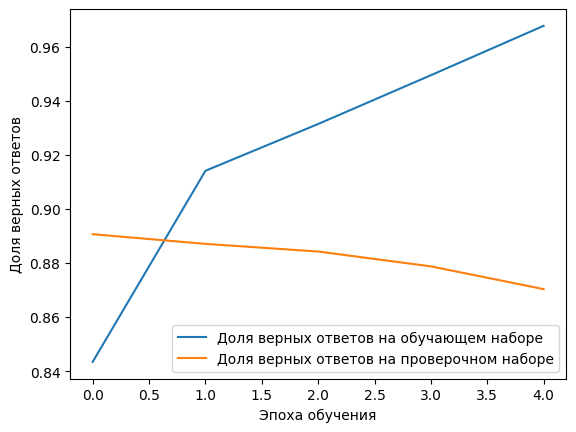

In [31]:
plt.plot(history_cnn.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_cnn.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Cеть LSTM

In [32]:
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, 32, input_length=max_news_len))
model_lstm.add(LSTM(16))
model_lstm.add(Dense(4, activation='softmax'))

2023-11-14 17:11:32.956057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-14 17:11:32.957597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-14 17:11:32.959242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [33]:
model_lstm.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [34]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 32)            320000    
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense_2 (Dense)             (None, 4)                 68        
                                                                 
Total params: 323,204
Trainable params: 323,204
Non-trainable params: 0
_________________________________________________________________


Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model.h5`

In [35]:
model_lstm_save_path = 'best_model_lstm.h5'
checkpoint_callback_lstm = ModelCheckpoint(model_lstm_save_path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [36]:
history_lstm = model_lstm.fit(x_train,
                              y_train,
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_lstm])

Epoch 1/5


2023-11-14 17:11:33.370762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-14 17:11:33.372714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-14 17:11:33.374552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

844/844 [==============================] - ETA: 0s - loss: 0.4911 - accuracy: 0.8282

2023-11-14 17:11:52.819943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-14 17:11:52.821735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-14 17:11:52.823548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_accuracy improved from -inf to 0.89167, saving model to best_model_lstm.h5
844/844 [==============================] - 21s 23ms/step - loss: 0.4911 - accuracy: 0.8282 - val_loss: 0.3171 - val_accuracy: 0.8917
Epoch 2/5
843/844 [============================>.] - ETA: 0s - loss: 0.2717 - accuracy: 0.9131
Epoch 2: val_accuracy did not improve from 0.89167
844/844 [==============================] - 18s 21ms/step - loss: 0.2716 - accuracy: 0.9131 - val_loss: 0.3214 - val_accuracy: 0.8873
Epoch 3/5
842/844 [============================>.] - ETA: 0s - loss: 0.2371 - accuracy: 0.9230
Epoch 3: val_accuracy did not improve from 0.89167
844/844 [==============================] - 18s 21ms/step - loss: 0.2373 - accuracy: 0.9229 - val_loss: 0.3294 - val_accuracy: 0.8848
Epoch 4/5
844/844 [==============================] - ETA: 0s - loss: 0.2145 - accuracy: 0.9296
Epoch 4: val_accuracy did not improve from 0.89167
844/844 [==============================] - 18s 21ms/step - loss: 0.2145 - 

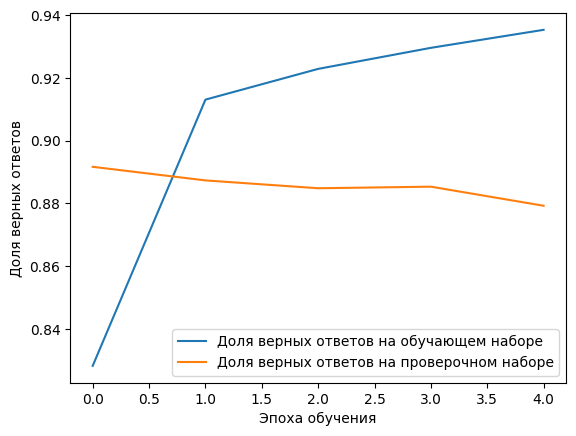

In [37]:
plt.plot(history_lstm.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_lstm.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Cеть GRU

In [38]:
model_gru = Sequential()
model_gru.add(Embedding(num_words, 32, input_length=max_news_len))
model_gru.add(GRU(16))
model_gru.add(Dense(4, activation='softmax'))

2023-11-14 17:13:06.690077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-14 17:13:06.692172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-14 17:13:06.693833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [39]:
model_gru.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [40]:
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 30, 32)            320000    
                                                                 
 gru (GRU)                   (None, 16)                2400      
                                                                 
 dense_3 (Dense)             (None, 4)                 68        
                                                                 
Total params: 322,468
Trainable params: 322,468
Non-trainable params: 0
_________________________________________________________________


Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model_gru.h5`

In [41]:
model_gru_save_path = 'best_model_gru.h5'
checkpoint_callback_gru = ModelCheckpoint(model_gru_save_path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [42]:
history_gru = model_gru.fit(x_train,
                              y_train,
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_gru])

Epoch 1/5


2023-11-14 17:13:07.078957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-14 17:13:07.080961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-14 17:13:07.082950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

843/844 [============================>.] - ETA: 0s - loss: 0.5611 - accuracy: 0.7968

2023-11-14 17:13:27.725154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-14 17:13:27.727067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-14 17:13:27.729092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_accuracy improved from -inf to 0.87417, saving model to best_model_gru.h5
844/844 [==============================] - 22s 23ms/step - loss: 0.5610 - accuracy: 0.7969 - val_loss: 0.3650 - val_accuracy: 0.8742
Epoch 2/5
843/844 [============================>.] - ETA: 0s - loss: 0.3119 - accuracy: 0.9001
Epoch 2: val_accuracy improved from 0.87417 to 0.88225, saving model to best_model_gru.h5
844/844 [==============================] - 19s 22ms/step - loss: 0.3119 - accuracy: 0.9000 - val_loss: 0.3390 - val_accuracy: 0.8823
Epoch 3/5
843/844 [============================>.] - ETA: 0s - loss: 0.2652 - accuracy: 0.9140
Epoch 3: val_accuracy improved from 0.88225 to 0.88667, saving model to best_model_gru.h5
844/844 [==============================] - 19s 23ms/step - loss: 0.2652 - accuracy: 0.9141 - val_loss: 0.3287 - val_accuracy: 0.8867
Epoch 4/5
843/844 [============================>.] - ETA: 0s - loss: 0.2358 - accuracy: 0.9237
Epoch 4: val_accuracy did not improve from 0.886

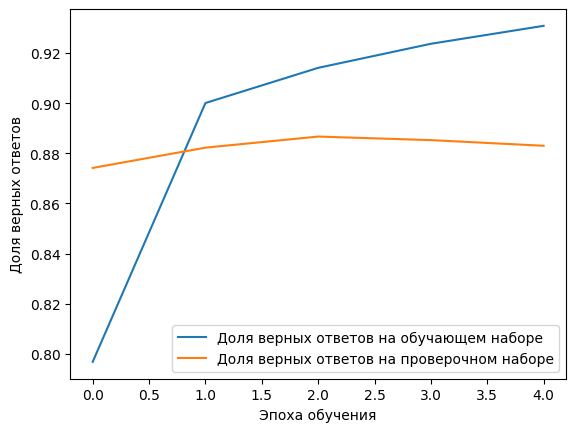

In [43]:
plt.plot(history_gru.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_gru.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Загружаем набор данных для тестирования

In [44]:
test = pd.read_csv('test.csv',
                    header=None,
                    names=['class', 'title', 'text'])

In [45]:
test

,class,title,text
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...
...,...,...,...
7595,1,Around the world,Ukrainian presidential candidate Viktor Yushch...
7596,2,Void is filled with Clement,With the supply of attractive pitching options...
7597,2,Martinez leaves bitter,Like Roger Clemens did almost exactly eight ye...
7598,3,5 of arthritis patients in Singapore take Bext...,SINGAPORE : Doctors in the United States have ...


Преобразуем новости в числовое представление

Обратите внимание, что нужно использовать токенизатор, обученный на наборе данных train.

In [46]:
test_sequences = tokenizer.texts_to_sequences(test['text'])

In [47]:
x_test = pad_sequences(test_sequences, maxlen=max_news_len)

In [48]:
x_test[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0, 2020, 3371,  449,   15, 6956,  252,   60,   33,
          28,  289,   12, 9088, 2184,  371,  169, 9284],
       [  92,  119,    4, 3472,    8,    1,  402,  134,   75, 5471, 1516,
        1227,    2, 3436,    8, 2744, 5220,  230,  936,   20, 2148,  117,
           1,   38,  561, 1974,    8,   14, 3957, 1218],
       [   2,   52, 5787,   18,    2, 4914,   15,    1,  525,    4, 4586,
         227,    2, 3922,    3, 1316,    2, 6888,    4, 2893,  576,   84,
          33,  758, 6515,    4,    1, 1013, 5154,    4],
       [9642, 1291,    6, 8714,   41,  671,   40, 2977,  177,    1,  108,
          26, 1027, 7300,   26,  760,    5, 3356,   40, 1271, 2450,   26,
        2170,   50, 3356,   26, 7415,    6, 9153,   26],
       [   0,    0,    0,    0,    0,    0,   39,  493, 7343,  832,  400,
         820,   28, 3827,    4,    1, 4474,   54, 9411,    1, 1273,   38,
        1230,    3, 1365,  348, 

Правильные ответы

In [49]:
y_test = utils.to_categorical(test['class'] - 1, nb_classes)

In [50]:
y_test

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

## Оцениваем качество работы сети на тестовом наборе данных

### Одномерная сверточная сеть

In [51]:
model_cnn.load_weights(model_cnn_save_path)

In [52]:
model_cnn.evaluate(x_test, y_test, verbose=1)

238/238 [==============================] - 1s 3ms/step - loss: 0.3178 - accuracy: 0.8943


[0.317779004573822, 0.8943421244621277]

### Сеть LSTM

In [53]:
model_lstm.load_weights(model_lstm_save_path)

In [54]:
model_lstm.evaluate(x_test, y_test, verbose=1)

238/238 [==============================] - 2s 6ms/step - loss: 0.3279 - accuracy: 0.8925


[0.32791852951049805, 0.8924999833106995]

### Сеть GRU

In [55]:
model_gru.load_weights(model_gru_save_path)

In [56]:
model_gru.evaluate(x_test, y_test, verbose=1)

238/238 [==============================] - 1s 6ms/step - loss: 0.3349 - accuracy: 0.8907


[0.33489781618118286, 0.890657901763916]

## Полезные ссылки

1. [Определение тональности текстов отзывов на сайте YELP одномерной сверточной нейросетью](https://colab.research.google.com/drive/1KWS-4MKKOIG7UhiCA58ZJcxwSLG5F6Wm).
2. [Определение тональности текстов отзывов на сайте YELP сетью LSTM](https://colab.research.google.com/drive/19olgYyZ4N5fh8RIPtHxkso2N5HD1yg0X).
3. [Использование командной строки Linux в Colab](https://colab.research.google.com/drive/1vFGZ2nDS0ukNGXPL-0avK097afYQILyq).